In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.cluster import KMeans

In [2]:
all_sheets = pd.read_excel('data/Portfolio_optimization_dataset.xlsx', sheet_name=None)

stocksPrices = all_sheets["Prix"]
additionalStocksPrices = all_sheets["Compléments Prix Fininfo"]
portfolios = all_sheets["Positions ptf"]
portfoliosPerformance = all_sheets["Performances"]
USDConversion = all_sheets["Taux de change USD"]

## Assets Prices

In [3]:
stocksPrices

,Code ISIN,Libellé,Date,Cours,Devise de cours
0,BE0974310428,X-FAB SILICON FOUNDRIES SE,2022-02-28,7.03,EUR
1,BE0974310428,X-FAB SILICON FOUNDRIES SE,2022-02-25,7.18,EUR
2,BE0974310428,X-FAB SILICON FOUNDRIES SE,2022-02-24,6.89,EUR
3,BE0974310428,X-FAB SILICON FOUNDRIES SE,2022-02-23,7.15,EUR
4,BE0974310428,X-FAB SILICON FOUNDRIES SE,2022-02-22,7.36,EUR
...,...,...,...,...,...
235948,US92826C8394,VISA CLASS A,2011-09-12,86.23,USD
235949,US92826C8394,VISA CLASS A,2011-09-09,86.36,USD
235950,US92826C8394,VISA CLASS A,2011-09-08,87.46,USD
235951,US92826C8394,VISA CLASS A,2011-09-07,88.48,USD


In [4]:
mapping_asset_names = stocksPrices[['Code ISIN', 'Libellé']].drop_duplicates().set_index('Code ISIN')['Libellé'].to_dict()

# Save to a file
with open("data/dictionary.json", "w") as file:
    json.dump(mapping_asset_names, file, indent=4)  


In [5]:
print(f"There are a total of {len(mapping_asset_names)} stocks.")

There are a total of 91 stocks.


In [6]:
def check_unique_devise_per_stock(df):
    # Group by 'Code ISIN' and check the number of unique values in 'devise'
    multiple_devises = df.groupby('Code ISIN')['Devise de cours'].nunique() > 1
    
    # Identify stocks with multiple devises
    if multiple_devises.any():
        stocks_with_multiple_devises = multiple_devises[multiple_devises].index.tolist()
        print("Warning: The following stocks have multiple devises:", stocks_with_multiple_devises)
        return False
    else:
        print("Each stock uses a unique devise for pricing.")
        return True

In [7]:
check_unique_devise_per_stock(stocksPrices)

Each stock uses a unique devise for pricing.


True

In [8]:
stocks_devise = stocksPrices.groupby('Code ISIN')['Devise de cours'].unique().apply(lambda x: x[0] if len(x) > 0 else x)
stocks_devise = pd.DataFrame(stocks_devise).reset_index()
stocks_devise.to_csv("data/Stocks_devise.csv", index=False) 
stocks_devise.head()

,Code ISIN,Devise de cours
0,BE0974310428,EUR
1,BE0974413453,EUR
2,DE0005557508,EUR
3,DE0008404005,EUR
4,DE0009770206,EUR


In [9]:
# Check for consecutive dates for each stock
def check_consecutive_dates(group):
    group = group.sort_values(by='Date')
    gaps = group['Date'].diff().dt.days > 1
    return gaps.any()  # True if there are gaps, False otherwise

# Group by 'id_stock' and check for gaps
stocks_with_gaps = stocksPrices.groupby('Code ISIN').apply(check_consecutive_dates,include_groups=False)

print(f"{stocks_with_gaps.sum()/len(stocks_with_gaps)*100}% of stocks contain gaps in their pricing time serie.")

100.0% of stocks contain gaps in their pricing time serie.


In [10]:
# Generate a full date range
start_date = pd.to_datetime("2020-01-01")

end_date = stocksPrices["Date"].max()
all_dates = pd.date_range(start=start_date, end=end_date)

# Pivot the DataFrame
pivoted_stocksPrices = (
    stocksPrices.pivot(index='Date', columns='Code ISIN', values='Cours')  # Pivot to wide format
    .reindex(all_dates)  # Reindex to include all dates
)

# Rename index to 'date' for clarity
pivoted_stocksPrices.index.name = 'Date'

In [11]:
#function to eliminate empty rows in a dataset
def EmptyRowsElimination(dfAssetPrices):

    # read dataset and extract its dimensions
    [Rows, Columns] = dfAssetPrices.shape
    dFrame = dfAssetPrices.iloc[0:Rows, 0:Columns]
    
    # call dropna method from Pandas 
    dFClean = dFrame.dropna(axis =0, how ='all')
    return dFClean

cleanStocksPrices = EmptyRowsElimination(pivoted_stocksPrices)

In [12]:
cleanStocksPrices

Code ISIN,BE0974310428,BE0974413453,DE0005557508,DE0008404005,DE0009770206,ES0118594417,ES0171996087,FR0000039620,FR0000051070,FR0000051732,...,IT0003497168,IT0005366767,NL0000235190,NL0000334118,NL0012817175,NL0014559478,NL0015000IY2,NL0015001W49,US0378331005,US92826C8394
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,4.180,NaN,14.610,221.50,NaN,10.22,31.710,34.65,2.870,75.4400,...,0.5595,12.500,133.52,102.95,13.500,NaN,NaN,NaN,300.0100,190.71
2020-01-03,4.425,NaN,14.614,219.05,NaN,10.07,31.740,34.70,2.890,75.0800,...,0.5577,12.500,134.04,101.70,13.500,NaN,NaN,NaN,299.1400,190.72
2020-01-06,4.270,NaN,14.578,217.70,NaN,10.11,31.730,34.60,2.915,74.1600,...,0.5526,12.000,133.46,100.15,13.500,NaN,NaN,NaN,299.4600,188.05
2020-01-07,4.290,NaN,14.606,218.20,NaN,10.13,32.600,34.95,2.890,77.0000,...,0.5476,11.900,132.00,104.65,13.500,NaN,NaN,NaN,299.2050,189.08
2020-01-08,4.475,NaN,14.548,218.30,NaN,10.35,32.570,35.15,2.925,77.0200,...,0.5317,12.100,134.38,105.90,13.500,NaN,NaN,NaN,303.9200,192.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,5.145,145.0,26.290,289.70,72.54,16.78,10.130,27.15,5.140,0.6814,...,0.2511,5.742,126.56,590.40,12.570,21.06,23.46,18.182,223.6700,277.00
2024-10-04,5.225,145.4,26.290,291.80,72.57,17.18,10.225,27.90,5.360,0.6774,...,0.2562,5.816,126.84,589.20,12.775,21.48,23.37,18.384,225.3314,277.00
2024-10-07,5.265,145.2,26.430,292.30,72.57,17.06,10.180,28.60,5.370,0.6730,...,0.2549,5.902,127.40,576.80,13.335,21.32,23.42,18.120,222.5000,277.00


In [13]:
# Calculate the percentage of NaN values in each column
cleanStocksPrices.isna().sum(axis=0)

Code ISIN
BE0974310428       0
BE0974413453     641
DE0005557508       0
DE0008404005       0
DE0009770206     278
                ... 
NL0014559478     288
NL0015000IY2     440
NL0015001W49    1049
US0378331005       0
US92826C8394       0
Length: 91, dtype: int64

In [14]:
def verify_nan_conditions(df):
    # Dictionnaire pour stocker les résultats
    result = {}
    
    for column in df.columns:
        # Extraire la série pour chaque colonne
        series = df[column]
        
        # Identifier l'indice du premier élément non-NaN
        first_valid_index = series.first_valid_index()
        
        if first_valid_index is not None:
            # Vérifier s'il y a des NaN après le premier élément non-NaN
            if series.loc[first_valid_index:].isna().any():
                result[column] = False  # Non conforme
            else:
                result[column] = True  # Conforme
    
    return result

verify_nan_conditions(cleanStocksPrices)

{'BE0974310428': True,
 'BE0974413453': True,
 'DE0005557508': True,
 'DE0008404005': True,
 'DE0009770206': True,
 'ES0118594417': True,
 'ES0171996087': True,
 'FR0000039620': True,
 'FR0000051070': True,
 'FR0000051732': True,
 'FR0000051807': True,
 'FR0000052292': True,
 'FR0000053324': True,
 'FR0000053951': True,
 'FR0000054470': True,
 'FR0000054900': True,
 'FR0000073272': True,
 'FR0000120073': True,
 'FR0000120172': True,
 'FR0000120321': True,
 'FR0000120404': True,
 'FR0000120578': True,
 'FR0000120644': True,
 'FR0000121014': True,
 'FR0000121121': True,
 'FR0000121147': True,
 'FR0000121667': True,
 'FR0000124141': True,
 'FR0000125338': True,
 'FR0000125486': True,
 'FR0000127771': True,
 'FR0000130452': True,
 'FR0000130809': True,
 'FR0000131104': True,
 'FR0000131906': True,
 'FR0000133308': True,
 'FR0000435505': True,
 'FR0000990095': True,
 'FR0004125920': True,
 'FR0004163111': True,
 'FR0004180578': True,
 'FR0006174348': True,
 'FR0007054358': True,
 'FR0010112

In [15]:
cleanStocksPrices.to_csv('data/Stocks_prices.csv', index=True)

### Fill missing values

In [16]:
def fill_nan_after_first_valid(df):
    # Create a copy to avoid modifying the original DataFrame
    filled_df = df.copy()
    
    for column in filled_df.columns:
        # Find the first valid index in the column
        first_valid_index = filled_df[column].first_valid_index()
        
        if first_valid_index is not None:  # If there is a valid value
            # Use `.loc` to modify the DataFrame directly, applying ffill
            filled_df.loc[first_valid_index:, column] = filled_df.loc[first_valid_index:, column].ffill()
    
    return filled_df

In [17]:
filledCleanStocksPrices = fill_nan_after_first_valid(cleanStocksPrices)

In [18]:
filledCleanStocksPrices

Code ISIN,BE0974310428,BE0974413453,DE0005557508,DE0008404005,DE0009770206,ES0118594417,ES0171996087,FR0000039620,FR0000051070,FR0000051732,...,IT0003497168,IT0005366767,NL0000235190,NL0000334118,NL0012817175,NL0014559478,NL0015000IY2,NL0015001W49,US0378331005,US92826C8394
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,4.180,NaN,14.610,221.50,NaN,10.22,31.710,34.65,2.870,75.4400,...,0.5595,12.500,133.52,102.95,13.500,NaN,NaN,NaN,300.0100,190.71
2020-01-03,4.425,NaN,14.614,219.05,NaN,10.07,31.740,34.70,2.890,75.0800,...,0.5577,12.500,134.04,101.70,13.500,NaN,NaN,NaN,299.1400,190.72
2020-01-06,4.270,NaN,14.578,217.70,NaN,10.11,31.730,34.60,2.915,74.1600,...,0.5526,12.000,133.46,100.15,13.500,NaN,NaN,NaN,299.4600,188.05
2020-01-07,4.290,NaN,14.606,218.20,NaN,10.13,32.600,34.95,2.890,77.0000,...,0.5476,11.900,132.00,104.65,13.500,NaN,NaN,NaN,299.2050,189.08
2020-01-08,4.475,NaN,14.548,218.30,NaN,10.35,32.570,35.15,2.925,77.0200,...,0.5317,12.100,134.38,105.90,13.500,NaN,NaN,NaN,303.9200,192.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-03,5.145,145.0,26.290,289.70,72.54,16.78,10.130,27.15,5.140,0.6814,...,0.2511,5.742,126.56,590.40,12.570,21.06,23.46,18.182,223.6700,277.00
2024-10-04,5.225,145.4,26.290,291.80,72.57,17.18,10.225,27.90,5.360,0.6774,...,0.2562,5.816,126.84,589.20,12.775,21.48,23.37,18.384,225.3314,277.00
2024-10-07,5.265,145.2,26.430,292.30,72.57,17.06,10.180,28.60,5.370,0.6730,...,0.2549,5.902,127.40,576.80,13.335,21.32,23.42,18.120,222.5000,277.00


There are null assets price!!

In [19]:
#function to compute asset returns 
def StockReturnsComputing(pivoted_stocksPrices):
    # Get the shape of the input DataFrame
    n_rows, n_columns = pivoted_stocksPrices.shape
    
    # Initialize an empty DataFrame with adjusted dimensions
    StockReturn = pd.DataFrame(
        np.zeros([n_rows - 1, n_columns]),
        columns=pivoted_stocksPrices.columns,
        index=pivoted_stocksPrices.index[1:]
    )
    
    # Compute the returns
    for j in range(n_columns):  # Loop over assets (columns)
        for i in range(n_rows - 1):  # Loop over daily prices (rows)
            price_today = pivoted_stocksPrices.iloc[i+1, j]
            price_yesterday = pivoted_stocksPrices.iloc[i, j]
            if pd.isna(price_today) or pd.isna(price_yesterday) or price_yesterday == 0:
                StockReturn.iloc[i, j] = None  # Assign None for invalid cases
            else:
                StockReturn.iloc[i, j] = (
                    (price_today - price_yesterday) / price_yesterday
                ) * 100
    
    return StockReturn


In [20]:
daily_returns = StockReturnsComputing(cleanStocksPrices)

In [21]:
#compute mean returns and variance covariance matrix of returns
meanReturns = np.nanmean(daily_returns, axis=0)
print('Mean returns of Stocks:\n',  meanReturns, '\n')


Mean returns of Stocks:
 [ 6.59755656e-02  6.68169921e-02  5.83249109e-02  3.68736212e-02
  5.10657775e-03  6.63602769e-02 -4.49648128e-02  7.77986294e-03
  9.11674380e-02 -2.68943617e-01 -3.63854495e-02  1.09815707e-01
 -3.15104531e-02  3.38808931e-02 -8.84410392e-02  2.49969053e-02
  6.47651883e-02  3.38808931e-02  1.83995894e-02  4.40397979e-02
  2.44155481e-02  2.02737629e-02 -2.33294732e-03  5.45374620e-02
  3.38561845e-02 -8.27928933e-02  5.07124090e-02  3.44778151e-02
  6.03088470e-02  2.57154461e-02 -2.89138819e-02  6.15867454e-03
  1.02324347e-02  3.80160023e-02  4.02045613e-02 -1.34253258e-02
  5.25497229e-03  1.20304160e-02  1.47005943e-02 -1.53213684e-02
  2.52524045e-02  2.95766234e-02  4.01556231e-02 -7.00664937e-02
  1.85264502e-02 -2.48316001e-02  5.65526569e-02  2.00787001e-01
  1.29286109e-02  9.01903357e-03 -3.49834568e-02 -1.60582722e-02
  1.53663335e-02  1.92640889e-02  3.43213424e-02  4.40367207e-02
  4.65366328e-03 -2.81195128e-02  8.04615800e-02 -1.24543827e-01


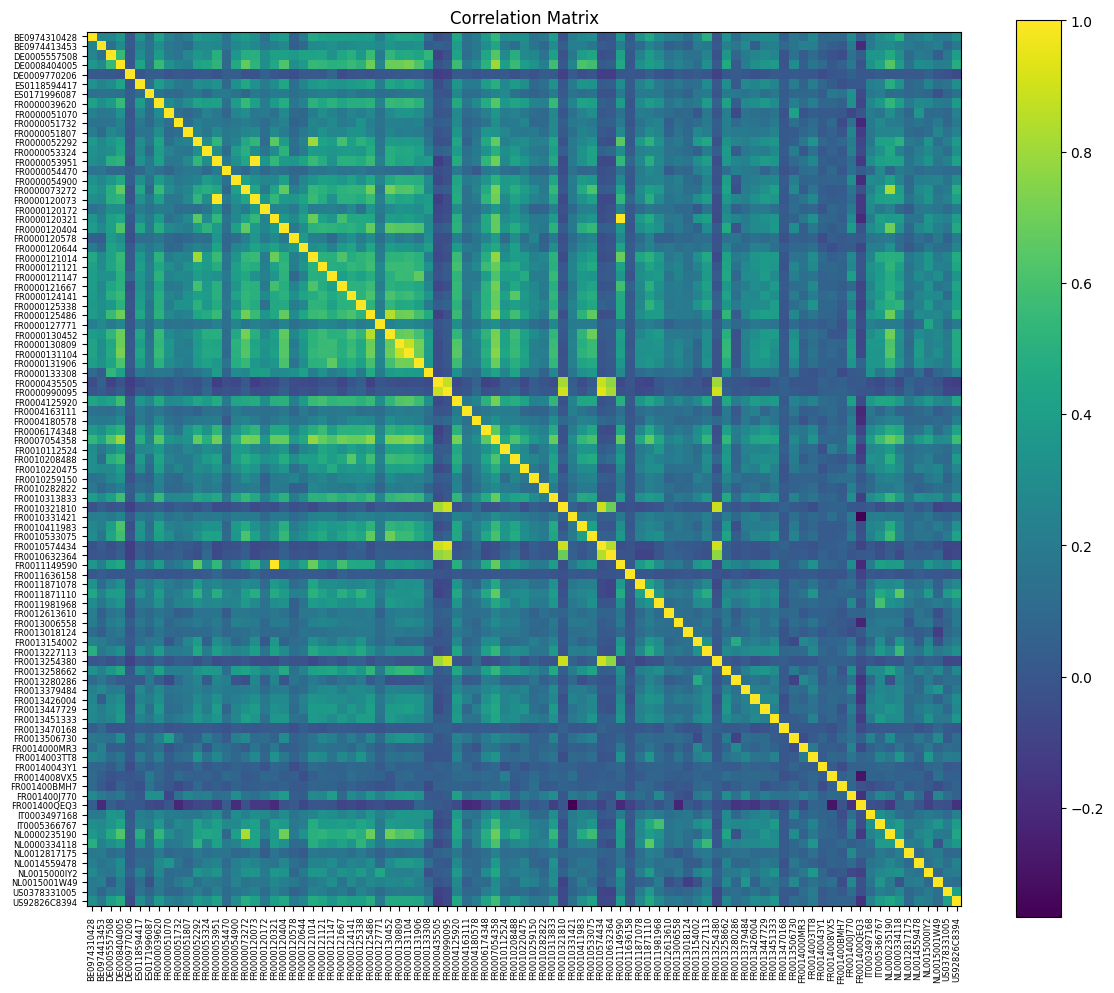

In [22]:
# Calculate the correlation and covariance matrix
cov_matrix = daily_returns.cov()
corr_matrix = daily_returns.corr()

# Create the plot
plt.figure(figsize=(12, 10)) 
plt.imshow(corr_matrix, cmap='viridis')

# Add the column names as axis labels
columns = daily_returns.columns
plt.xticks(ticks=range(len(columns)), labels=columns, rotation=90, fontsize=6) 
plt.yticks(ticks=range(len(columns)), labels=columns, fontsize=6)

# Add a colorbar to show the scale
plt.colorbar()

# Add a title
plt.title("Correlation Matrix")

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label overlap
plt.show()

## Portfolios

In [39]:
date_construction_portfolio = "2024-08-13" # A confirmer

In [40]:
portfolios['Construction_Date'] = pd.to_datetime(date_construction_portfolio)

In [41]:
portfolios

,Portefeuille,ISIN,Libellé ISIN,Quantité,Construction_Date
0,45850000090000027072,FR0000051070,MAUREL PROM,383.0,2024-08-13
1,45850000090000027072,FR0000052292,HERMES INTERNATIONAL,20.0,2024-08-13
2,45850000090000027072,FR0000073272,SAFRAN SA,210.0,2024-08-13
3,45850000090000027072,FR0000120321,L'OREAL SA,100.0,2024-08-13
4,45850000090000027072,FR0000121014,LVMH SA,140.0,2024-08-13
...,...,...,...,...,...
198,458500000900000745965,FR0014008VX5,EUROAPI,650.0,2024-08-13
199,458500000900000745965,IT0003497168,TELECOM ITALIA,18000.0,2024-08-13
200,458500000900000745965,NL0012817175,ALFEN N.V.,135.0,2024-08-13
201,458500000900000745965,US0378331005,APPLE INC,66.0,2024-08-13


In [42]:
# Merge Portfolio Data with Stock Prices
merged_df_portfolios = portfolios.merge(
    stocksPrices[["Code ISIN","Date","Cours","Devise de cours"]],
    left_on=["ISIN", "Construction_Date"],
    right_on=["Code ISIN", "Date"],
    how="left"
).drop(columns=["Date","Code ISIN"],axis=1)
merged_df_portfolios = merged_df_portfolios.merge(
    USDConversion[['Date','Cours EUR vers USD']],
    left_on=["Construction_Date"],
    right_on=["Date"],
    how="left"
).drop(columns=["Date"],axis=1)
# Calculate Asset Value
merged_df_portfolios['Valeur_EUR'] = np.where(
    merged_df_portfolios["Devise de cours"] == "EUR", 
    merged_df_portfolios["Quantité"] * merged_df_portfolios["Cours"], 
    merged_df_portfolios["Quantité"] * merged_df_portfolios["Cours"] / merged_df_portfolios["Cours EUR vers USD"]
)

# Calculate Total Portfolio Value
merged_df_portfolios["total_portfolio_value_EUR"] = merged_df_portfolios.groupby("Portefeuille")["Valeur_EUR"].transform("sum")
# Calculate asset weights
merged_df_portfolios["asset_weight"] = merged_df_portfolios["Valeur_EUR"] / merged_df_portfolios["total_portfolio_value_EUR"]
merged_df_portfolios[merged_df_portfolios["Portefeuille"]=="45850000090000027072"]


,Portefeuille,ISIN,Libellé ISIN,Quantité,Construction_Date,Cours,Devise de cours,Cours EUR vers USD,Valeur_EUR,total_portfolio_value_EUR,asset_weight
0,45850000090000027072,FR0000051070,MAUREL PROM,383.00000,2024-08-13,5.455,EUR,1.0931,2089.26500,402261.54754,0.005194
1,45850000090000027072,FR0000052292,HERMES INTERNATIONAL,20.00000,2024-08-13,2035.000,EUR,1.0931,40700.00000,402261.54754,0.101178
2,45850000090000027072,FR0000073272,SAFRAN SA,210.00000,2024-08-13,193.050,EUR,1.0931,40540.50000,402261.54754,0.100781
3,45850000090000027072,FR0000120321,L'OREAL SA,100.00000,2024-08-13,376.800,EUR,1.0931,37680.00000,402261.54754,0.093670
4,45850000090000027072,FR0000121014,LVMH SA,140.00000,2024-08-13,634.200,EUR,1.0931,88788.00000,402261.54754,0.220722
5,45850000090000027072,FR0000121147,FORVIA,150.00000,2024-08-13,9.154,EUR,1.0931,1373.10000,402261.54754,0.003413
6,45850000090000027072,FR0000125338,CAPGEMINI,90.00000,2024-08-13,177.300,EUR,1.0931,15957.00000,402261.54754,0.039668
7,45850000090000027072,FR0000125486,VINCI SA,550.00000,2024-08-13,103.250,EUR,1.0931,56787.50000,402261.54754,0.141171
8,45850000090000027072,FR0000130452,EIFFAGE,90.00000,2024-08-13,90.240,EUR,1.0931,8121.60000,402261.54754,0.020190
9,45850000090000027072,FR0000130809,SOCIETE GENERALE,200.00000,2024-08-13,20.535,EUR,1.0931,4107.00000,402261.54754,0.010210


## Portfolios Performances

In [32]:
portfoliosPerformance[portfoliosPerformance['Portefeuille'] == '45850000090000027072']

,Portefeuille,HPA_Dat,Montant patrimoine en euros,Performance (%)
0,45850000090000027072,2024-08-12,458764.96,-0.240016
1,45850000090000027072,2024-08-13,459893.78,0.005449
2,45850000090000027072,2024-08-14,463332.96,0.753311
3,45850000090000027072,2024-08-15,467462.72,1.651341
4,45850000090000027072,2024-08-16,469353.28,2.062449
5,45850000090000027072,2024-08-19,473912.40,3.053845
6,45850000090000027072,2024-08-20,474370.21,3.153398
7,45850000090000027072,2024-08-21,475899.15,3.485871
8,45850000090000027072,2024-08-22,476653.96,3.650007
9,45850000090000027072,2024-08-23,478260.43,3.999339


In [33]:
import plotly.express as px

fig = px.line(
    portfoliosPerformance,
    x="HPA_Dat",
    y="Performance (%)",
    color="Portefeuille",
    title="Portfolio Performance Over Time",
    labels={"HPA_Dat": "Date", "Performance (%)": "Performance (%)"},
    markers=True
)

# Show the plot
fig.show()

## Heuristic Portfolio Selection

In [173]:
list_of_assets_ISIN = list(mapping_asset_names.keys())
list_of_assets_name = list(mapping_asset_names.values())

In [167]:
#prepare asset parameters for k-means clustering
#reshape for concatenation
meanReturns = meanReturns.reshape(len(meanReturns),1)
assetParameters = np.concatenate([meanReturns, cov_matrix], axis = 1)
print('Size of the asset parameters for clustering:\n', assetParameters.shape)
print('Asset parameters for clustering:\n', assetParameters)

Size of the asset parameters for clustering:
 (91, 92)
Asset parameters for clustering:
 [[ 0.06597557  9.45317612  0.93955496 ...  1.20416524  1.77923512
   1.6656711 ]
 [ 0.06681699  0.93955496  2.54316121 ...  0.72591702  0.24201497
   0.32892552]
 [ 0.05832491  1.07339323  0.21277533 ...  0.08715175  0.70878672
   0.91173026]
 ...
 [-0.25487477  1.20416524  0.72591702 ...  5.10256581  0.47330147
   0.29492873]
 [ 0.04797227  1.77923512  0.24201497 ...  0.47330147  8.49490791
   2.04470868]
 [ 0.04526952  1.6656711   0.32892552 ...  0.29492873  2.04470868
   2.99346573]]


In [171]:
#kmeans clustering of assets using the characteristic vector of 
#mean return and variance-covariance vector of returns

n_clusters = 15 ## A régler

assetsCluster= KMeans(n_clusters=n_clusters)
assetsCluster.fit(assetParameters)
print('Clustering of assets completed!') 
labels = assetsCluster.labels_

Clustering of assets completed!


In [ ]:
#fixing asset labels to cluster points
print('Stocks in each of the clusters:\n',)
assets_ISIN = np.array(list_of_assets_ISIN)
for i in range(n_clusters):
    print(f'********************** Cluster {i+1} **********************')
    clt  = np.where(labels == i)
    assetsCluster = assets_ISIN[clt]
    print(assetsCluster)

Stocks in each of the clusters:

********************** Cluster 1 **********************
['FR0000131906' 'FR0012613610' 'FR0013018124' 'FR0013227113'
 'NL0000334118']
********************** Cluster 2 **********************
['FR001400QEQ3']
********************** Cluster 3 **********************
['FR0004180578' 'FR0010112524' 'FR0013379484' 'FR0013426004'
 'FR001400J770']
********************** Cluster 4 **********************
['FR0000053324' 'FR0000073272' 'FR0000120404' 'FR0000120644'
 'FR0000121147' 'FR0000124141' 'FR0000125486' 'FR0000127771'
 'FR0000131104' 'FR0004125920' 'FR0010208488' 'FR0010574434'
 'FR0011981968' 'FR001400BMH7' 'IT0003497168' 'IT0005366767'
 'NL0015001W49' 'US0378331005']
********************** Cluster 5 **********************
['FR0000051732']
********************** Cluster 6 **********************
['FR0014008VX5']
********************** Cluster 7 **********************
['FR0010313833' 'FR0013280286' 'FR0013447729' 'FR0013470168'
 'NL0000235190' 'US92826C8394']

In [175]:
#fixing asset labels to cluster points
print('Stocks in each of the clusters:\n',)
assets_name = np.array(list_of_assets_name)
for i in range(n_clusters):
    print(f'********************** Cluster {i+1} **********************')
    clt  = np.where(labels == i)
    assetsCluster = assets_name[clt]
    print(assetsCluster)

Stocks in each of the clusters:

********************** Cluster 1 **********************
['RENAULT SA' 'PRODWAYS GROUP' 'NICOX' 'SOITEC' 'ASM INTERNATIONAL NV']
********************** Cluster 2 **********************
['NICOX BSA 2024']
********************** Cluster 3 **********************
['SWORD GROUP' 'NEXITY' 'SOLUTIONS 30 SE' 'CLARANOVA'
 'AIR FRANCE-KLM RGPT 2023']
********************** Cluster 4 **********************
['COMPAGNIE DES ALPES' 'SAFRAN SA' 'ACCOR SA' 'DANONE SA' 'FORVIA'
 'VEOLIA ENVIRONNEMENT SA' 'VINCI SA' 'VIVENDI SA' 'BNP PARIBAS SA'
 'AMUNDI' 'ENGIE' 'ODDO BHF GENERATION CR EUR' 'WORLDLINE' 'TERACT'
 'TELECOM ITALIA' 'NEXI SPA' 'PLUXEE' 'APPLE INC']
********************** Cluster 5 **********************
['ATOS']
********************** Cluster 6 **********************
['EUROAPI']
********************** Cluster 7 **********************
['ARKEMA' 'BIOMERIEUX SA' 'VERALLIA SA' 'IMPLANET SA' 'AIRBUS'
 'VISA CLASS A']
********************** Cluster 8 *************